<a href="https://colab.research.google.com/github/aydn0823/2025-ergotic-system/blob/main/ayidana_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

任务4目的

研究脑电信号的潜在特征
关键技能

频谱密度计算、小波变换


任务：

1.从数据库下载脑电图记录： https://zenodo.org/records/2547147#.Y7eU5uxBwlI 选择 任何 EDF 格式的文件。

2.使用数据集中的注释，找出脑电图记录中显示癫痫发作的位置。

3.绘制癫痫发作时的脑电图时间相关性图（选择时间范围和比例，以便显示癫痫发作）。 选择时间范围和比例，以便清晰可见）。

4.将所有脑电图通道平均为一个 (将所有通道相加除以通道数）。

5.去除信号中所有高于 60 赫兹的频率。

对于这种转换后的信号 1) 构建信号的频谱图； 2) 构建小波变换（频谱图）。

参考解决方案链接： https://github.com/TAUforPython/wavelets/blob/main/wavelets_cwt_dwt_example_EEG_ECG.ipynb


In [ ]:

!pip install pywavelets mne --quiet
!wget https://zenodo.org/records/2547147/files/eeg1.edf?download=1 -O eeg10.edf

--2025-05-12 18:03:17--  https://zenodo.org/records/2547147/files/eeg1.edf?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75194368 (72M) [application/octet-stream]
Saving to: ‘eeg10.edf’

eeg10.edf           100%[===================>]  71.71M  24.1MB/s    in 3.0s    

2025-05-12 18:03:21 (24.1 MB/s) - ‘eeg10.edf’ saved [75194368/75194368]



In [ ]:
"""
单元格 1: 安装库、导入、全局参数
目标: 设置运行环境，定义文件路径和分析参数
"""
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig # 从 scipy.signal 导入 sig
import pywt
import os
import matplotlib as mpl # 导入 mpl 用于设置字体


# --- 全局参数设置 ---
edf_file_path = 'eeg10.edf' # <--- **重要：这里设置为您实际下载的文件名**

seizure_start_sec_fallback = 2996
seizure_end_sec_fallback = 3036

# 滤波参数 (任务要求去除高于 60 Hz 的频率，我们同时添加陷波滤波去除工频干扰)
filter_cutoff_freq = 60  # Hz, 低通滤波器的截止频率 (任务要求 < 60 Hz)
powerline_freq = 50      # Hz, 工频干扰频率。根据之前的 PSD 分析，您的文件主要干扰在 50 Hz。
notch_quality_factor = 30 # 陷波滤波器的品质因数 Q (mne 的陷波方法不需要此参数，但保留注释)

# 时频分析参数 (参考 solution 或常用值)
# 频谱图参数: NFFT (窗口长度), noverlap (重叠点数)
# 参考 solution 使用 NFFT=256, noverlap=108
nfft_spec = 512 # 常用值，提供更好的频率分辨率
noverlap_spec = 400 # 常用值，提供时间平滑度 (例如 75% 重叠)

# 小波变换参数
wavelet_name = 'cmor1.5-1.0' # 参考 solution 使用的小波
min_freq_cwt = 1 # Hz, 小波分析的最低频率 (需要较大计算范围以减少边缘效应)
max_freq_cwt = 50 # Hz, 小波分析的最高频率 (参考 solution 使用 50 Hz)
num_freqs_cwt = 100 # 小波图中的频率点数量 (尺度数量)

# 分析窗口参数 (相对于检测到的癫痫发作时间)
# 我们将分析一个包含癫痫发作的固定时长的窗口
buffer_before_seizure = 5 # 秒, 分析窗口在发作开始前多久开始
buffer_after_seizure = 5 # 秒, 分析窗口在发作结束之后持续多久

# --- Matplotlib 字体设置 (使用英文标签，避免中文显示配置问题) ---
# 在图表中使用英文标签和标题，避免中文显示配置问题
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] # 或者其他 Colab 环境中默认可用的字体
plt.rcParams['axes.unicode_minus'] = False # 确保负号显示正常

print("单元格 1 运行完毕：库已安装，导入完成，全局参数已设置。")

单元格 1 运行完毕：库已安装，导入完成，全局参数已设置。


In [ ]:
# -*- coding: utf-8 -*-
"""
单元格 2: 加载数据并确定癫痫发作时间
目标: 读取 EDF 文件，找到癫痫发作的起始和持续时间
依赖: edf_file_path, seizure_start_sec_fallback, seizure_end_sec_fallback
输出: raw (mne Raw 对象), sfreq, info (mne Info 对象), seizure_onset_time, seizure_duration, seizure_description
"""

# 请确保您已经运行了单元格 1，并且 edf_file_path 指向正确的文件名。
# **重要：请务必在此之前运行 !wget 命令下载文件。**

raw = None # 初始化 raw 变量
sfreq = None
info = None
seizure_onset_time = None
seizure_duration = None
seizure_description = "No annotation found, using fallback time" # 默认描述

# --- 加载 EDF 文件 ---
try:
    # 使用 mne 加载 EDF 文件，preload=True 将数据加载到内存
    # verbose=False 减少输出信息
    print(f"\n正在加载文件: {edf_file_path} ...")
    # 参考 solution 使用 preload=True
    raw = mne.io.read_raw_edf(edf_file_path, preload=True, verbose=False)
    print("文件加载成功。")

    info = raw.info
    sfreq = info['sfreq']       # 采样频率
    n_times_total = raw.n_times # 总采样点数
    ch_names_total = raw.ch_names # 所有通道名称

    print(f"采样频率: {sfreq} Hz")
    print(f"总采样点数: {n_times_total}")
    print(f"通道数量: {len(ch_names_total)}")
    print(f"记录总时长: {raw.times[-1]:.2f} 秒") # raw.times 是时间向量


    # 尝试根据通道名称识别 EEG 通道类型 (如果文件中未明确指定类型)
    # 这有助于 mne 的 picks 参数选择 'eeg'
    try:
        # 尝试根据名称中的关键词设定通道类型，这些关键词覆盖了 CHB-MIT 的命名习惯
        raw.set_channel_types({ch_name: 'eeg' for ch_name in ch_names_total if any(key in ch_name.lower() for key in ['eeg', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'cz', 'pz', 'fz'])})
        # 过滤掉非 EEG 通道，只保留 EEG 通道名称列表
        # raw.copy().pick_types('eeg').ch_names 会只保留 EEG 通道的名称
        eeg_channel_names = raw.copy().pick_types('eeg').ch_names
        print(f"已识别 {len(eeg_channel_names)} 个 EEG 通道。")
    except Exception:
         print("未能自动识别 EEG 通道名称。将尝试根据类型选择或使用所有通道。")
         eeg_channel_names = raw.ch_names # 如果失败，使用所有通道名作为备选


    # --- 根据注释查找癫痫发作时刻 (参考 solution 方法) ---
    print("\n正在文件中搜索癫痫发作注释...")
    if raw.annotations:
        print("找到以下文件注释:")
        print(raw.annotations)
        # 查找与癫痫发作相关的注释
        seizure_keywords_to_look_for = ['seizure', 'seiz', 'bckg+seiz', 'ictal'] # 常见的癫痫关键词
        found_annotation = False
        for annot in raw.annotations:
            # 检查注释描述是否包含癫痫关键词 (不区分大小写)
            if any(keyword in annot['description'].lower() for keyword in seizure_keywords_to_look_for):
                seizure_onset_time = annot['onset']      # 癫痫开始时间（相对于记录开始的秒数）
                seizure_duration = annot['duration']    # 癫痫持续时间
                seizure_description = annot['description'] # 注释描述
                print(f"\n找到癫痫发作注释: '{seizure_description}'")
                print(f"癫痫开始时间 (来自注释): {seizure_onset_time:.2f} 秒")
                print(f"癫痫持续时间 (来自注释): {seizure_duration:.2f} 秒")
                found_annotation = True
                break # 找到第一个癫痫注释就停止

        if not found_annotation:
            print(f"\n文件中未找到常见的癫痫发作注释。")


    # --- 如果未找到注释，使用备选的硬编码时间 ---
    if seizure_onset_time is None:
        seizure_onset_time = seizure_start_sec_fallback
        seizure_duration = seizure_end_sec_fallback - seizure_start_sec_fallback
        seizure_description = f"使用备选时间: {seizure_start_sec_fallback:.2f}s - {seizure_end_sec_fallback:.2f}s"
        print(seizure_description)

    # 确保最终确定的癫痫时间范围在记录时长内
    if seizure_onset_time >= raw.times[-1]:
         print(f"警告: 癫痫开始时间 {seizure_onset_time:.2f} 秒超出记录总时长 {raw.times[-1]:.2f} 秒。已调整。")
         seizure_onset_time = raw.times[-1]
         seizure_duration = 0 # 如果在最后，持续时间为 0
    if seizure_onset_time + seizure_duration > raw.times[-1]:
         print(f"警告: 癫痫结束时间 {seizure_onset_time + seizure_duration:.2f} 秒超出记录总时长 {raw.times[-1]:.2f} 秒。已裁剪持续时间。")
         seizure_duration = raw.times[-1] - seizure_onset_time


except FileNotFoundError:
    print(f"错误：文件 '{edf_file_path}' 未找到。请检查文件路径和名称，并确保文件已下载或上传到 Colab 环境中。")
except Exception as e:
    print(f"加载或处理 EDF 文件时出错: {e}")
    raw = None # 确保 raw 在加载失败时为 None

# 注：如果在单元格 2 运行失败，后续依赖 raw 的单元格将无法运行。


正在加载文件: eeg10.edf ...
文件加载成功。
采样频率: 256.0 Hz
总采样点数: 1790208
通道数量: 21
记录总时长: 6993.00 秒
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
未能自动识别 EEG 通道名称。将尝试根据类型选择或使用所有通道。

正在文件中搜索癫痫发作注释...
使用备选时间: 2996.00s - 3036.00s



正在绘制癫痫发作前后的原始脑电图...
绘图范围从 2986.00 秒到 3046.00 秒 (总时长: 60.00 秒)
Using matplotlib as 2D backend.


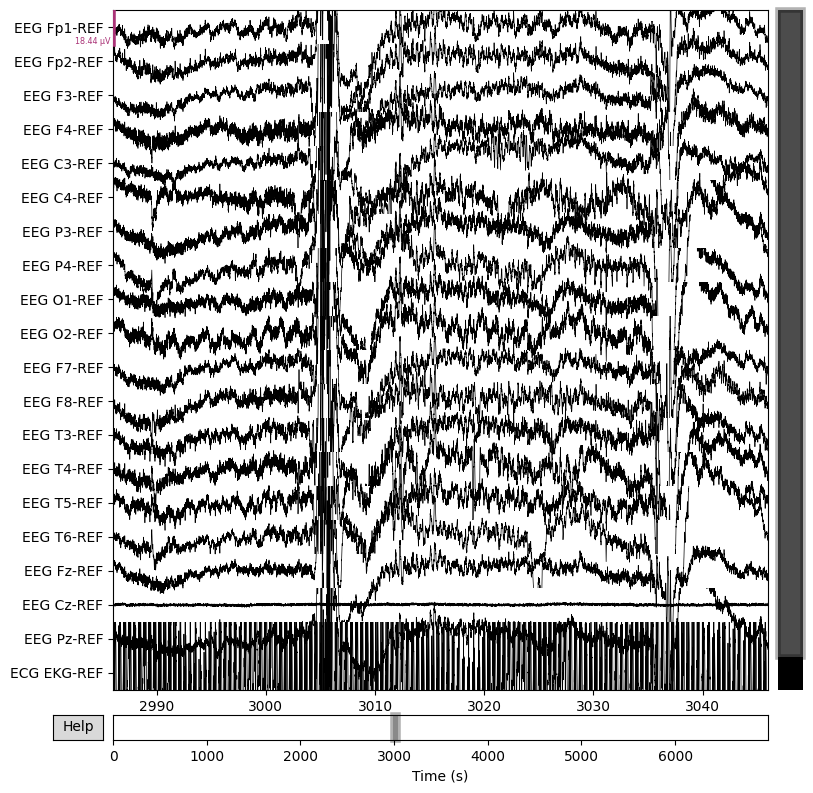

In [ ]:
# -*- coding: utf-8 -*-
"""
单元格 3: 绘制癫痫发作期间的原始脑电图
目标: 可视化原始 EEG 信号在癫痫发作时段的表现
依赖: raw, seizure_onset_time, seizure_duration, seizure_description
"""

# 请确保您已经运行了单元格 2，并且 raw 对象已成功加载，seizure 时间已确定。

if raw is not None and seizure_onset_time is not None and seizure_duration is not None:
    print("\n正在绘制癫痫发作前后的原始脑电图...")

    # 定义绘图的时间范围 (在癫痫开始和结束时间前后加一些缓冲)
    # 参考 solution 绘制的是一个固定时长的段，我们选择发作前后加一些缓冲
    plot_start_time = max(0, seizure_onset_time - 10) # 提前10秒以便观察发作前的变化
    plot_end_time = seizure_onset_time + seizure_duration + 10 # 延后10秒以便观察发作后的情况
    plot_duration = plot_end_time - plot_start_time

    print(f"绘图范围从 {plot_start_time:.2f} 秒到 {plot_end_time:.2f} 秒 (总时长: {plot_duration:.2f} 秒)")

    try:
        # 使用 mne 的 plot 方法进行绘制，这将显示所有通道
        # scalings='auto' 自动调整通道幅度以便清晰显示不同通道的波形
        # title 使用英文，包含癫痫描述
        fig_raw = raw.plot(start=plot_start_time, duration=plot_duration,
                           scalings='auto',
                           title=f'Raw EEG around Seizure ({seizure_description})',
                           show=True, # 在 notebook 里可以直接显示图表
                           block=False) # block=False 避免阻塞后续代码运行

        # 如果想保存图表，可以使用 fig_raw.savefig('raw_eeg_seizure.png')

    except Exception as e:
        print(f"绘制原始 EEG 图时出错: {e}")

else:
    print("原始数据未加载或癫痫时间未确定。无法绘制原始脑电图。请检查单元格 2。")


正在对原始数据应用滤波...
正在应用 50 Hz 陷波滤波器 (对 EEG 通道)...
陷波滤波器已应用。
正在应用 60 Hz 低通滤波器 (对 EEG 通道)...
低通滤波器已应用。
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


未能在分析时段中选择 EEG 通道数据。将提取所有通道数据。
正在对分析时段的数据进行通道平均...
分析时段通道平均完成。

最终用于时频分析的时间范围: 2991.00 秒到 3041.00 秒 (总时长: 50.00 秒)。
用于分析的信号段点数: 12801


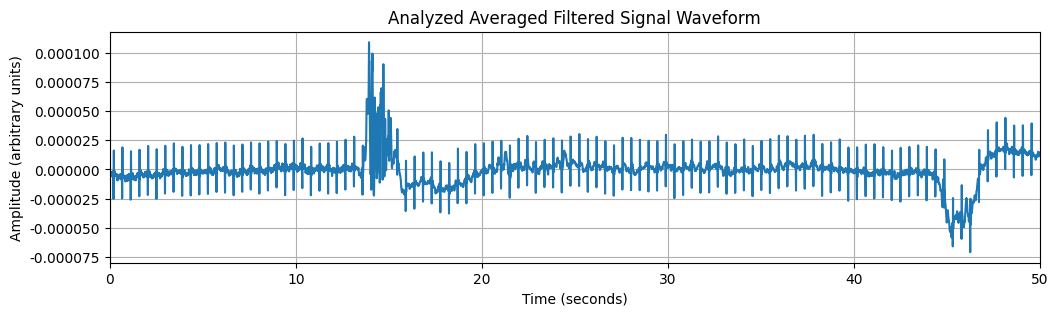

In [ ]:
# -*- coding: utf-8 -*-
"""
单元格 4: 数据预处理 (滤波, 截取分析段, 通道平均)
目标: 对信号进行滤波和平均，准备用于时频分析的数据段
依赖: raw, sfreq, seizure_onset_time, seizure_duration,
      powerline_freq, filter_cutoff_freq, buffer_before_seizure, buffer_after_seizure
输出: averaged_analysis_segment (分析用的平均信号段 numpy 数组),
      times_analysis_segment (分析信号段对应的时间向量 numpy 数组),
      analysis_start_time, analysis_duration, seizure_description
"""
# 请确保您已经运行了单元格 2，并且 raw 对象已成功加载，seizure 时间已确定。

averaged_analysis_segment = None
times_analysis_segment = None
analysis_start_time = None
analysis_duration = None

if raw is not None and seizure_onset_time is not None and seizure_duration is not None:
    print("\n正在对原始数据应用滤波...")

    # 对原始 raw 数据应用滤波 (使用 mne 方法更集成)
    # 创建一个副本进行滤波，不修改原始 raw 对象
    raw_filtered = raw.copy()

    # --- 应用陷波滤波器 (去除工频干扰) ---
    # 根据之前的 PSD 分析，主要干扰在 50 Hz
    try:
        print(f"正在应用 {powerline_freq} Hz 陷波滤波器 (对 EEG 通道)...")
        # picks='eeg' 只对标记为 EEG 类型的通道应用滤波
        # filter_length='auto', phase='zero', fir_design='firwin' 是 MNE FIR 滤波推荐的参数
        raw_filtered.notch_filter(powerline_freq, picks='eeg',
                                   filter_length='auto', phase='zero', fir_design='firwin',
                                   verbose=False) # verbose=False 减少输出信息
        print("陷波滤波器已应用。")
    except Exception as e:
        print(f"应用陷波滤波器时出错: {e}")
        print("将跳过陷波滤波继续。")


    # --- 应用低通滤波器 (去除高于 filter_cutoff_freq 的频率) ---
    # 任务要求去除所有高于 60 Hz 的频率
    try:
        print(f"正在应用 {filter_cutoff_freq} Hz 低通滤波器 (对 EEG 通道)...")
        # l_freq=None 表示高通禁用，h_freq 是低通截止频率
        raw_filtered.filter(l_freq=None, h_freq=filter_cutoff_freq,
                            picks='eeg', # 只对标记为 EEG 类型的通道应用滤波
                            filter_length='auto', phase='zero', fir_design='firwin',
                            verbose=False) # verbose=False 减少输出信息
        print("低通滤波器已应用。")
    except Exception as e:
        print(f"应用低通滤波器时出错: {e}")
        print("将跳过低通滤波继续。")


    # --- 定义用于时频分析的时间范围 ---
    # 我们选择一个包含癫痫发作点，前后带有缓冲的窗口
    # buffer_before_seizure 和 buffer_after_seizure 在单元格 1 中定义
    analysis_start_time = max(0, seizure_onset_time - buffer_before_seizure)
    # 分析总时长 = 发作时长 + 前缓冲 + 后缓冲
    analysis_duration = seizure_duration + buffer_before_seizure + buffer_after_seizure
    analysis_end_time = analysis_start_time + analysis_duration # 计算结束时间，用于 print 和检查

    # 确保分析范围不超出记录时长
    if analysis_end_time > raw_filtered.times[-1]:
        print(f"警告: 分析结束时间 {analysis_end_time:.2f} 秒超出记录总时长 {raw_filtered.times[-1]:.2f} 秒。将裁剪分析时长。")
        analysis_duration = raw_filtered.times[-1] - analysis_start_time
        analysis_end_time = raw_filtered.times[-1]
        # 如果开始时间已经在记录之外，则持续时间为0
        if analysis_duration < 0: analysis_duration = 0


    # --- 从滤波后的数据中截取分析范围内的 EEG 通道数据 ---
    # 使用 mne 的 crop 方法截取时段
    # crop 使用 tmin 和 tmax (包含 tmin，不包含 tmax)
    # 或者使用 tmin 和 duration
    raw_analysis_segment = raw_filtered.copy().crop(tmin=analysis_start_time, tmax=analysis_start_time + analysis_duration)

    # 从截取的 mne 对象中获取数据数组和对应的时间向量
    # picks='eeg' 会只选择标记为 EEG 类型的通道
    try:
        data_analysis_segment, times_analysis_segment = raw_analysis_segment.get_data(picks='eeg', return_times=True)
        eeg_channel_names_segment = raw_analysis_segment.copy().pick_types('eeg').ch_names
        print(f"已从分析时段提取 {len(eeg_channel_names_segment)} 个 EEG 通道的数据。")
    except ValueError:
         print("未能在分析时段中选择 EEG 通道数据。将提取所有通道数据。")
         data_analysis_segment, times_analysis_segment = raw_analysis_segment.get_data(return_times=True)
         eeg_channel_names_segment = raw_analysis_segment.ch_names # 如果失败，使用所有通道名

    # --- 通道平均 (对截取出来的分析数据段进行平均) ---
    # 任务要求将所有 EEG 通道平均为一个信号
    # 对选中的通道数据按行 (axis=0) 进行平均，结果是一个时间序列 (1D numpy 数组)
    print("正在对分析时段的数据进行通道平均...")
    averaged_analysis_segment = np.mean(data_analysis_segment, axis=0)
    print("分析时段通道平均完成。")


    print(f"\n最终用于时频分析的时间范围: {analysis_start_time:.2f} 秒到 {analysis_start_time + analysis_duration:.2f} 秒 (总时长: {analysis_duration:.2f} 秒)。")
    print(f"用于分析的信号段点数: {len(averaged_analysis_segment)}")

    # --- 绘制用于分析的平均信号波形图 (可选，用于检查) ---
    # 这将绘制经过滤波和平均后的，用于计算频谱图和小波图的信号段
    plt.figure(figsize=(12, 3))
    plt.plot(times_analysis_segment, averaged_analysis_segment) # 绘图使用 analysis_time_vector
    plt.title("Analyzed Averaged Filtered Signal Waveform") # 标题英文
    plt.xlabel("Time (seconds)") # 标签英文
    plt.ylabel("Amplitude (arbitrary units)") # 标签英文
    # 将 X 轴范围限制在实际分析的时间段
    plt.xlim(times_analysis_segment[0], times_analysis_segment[-1])
    plt.grid(True)
    plt.show()


else:
    print("原始数据未加载或癫痫时间未确定。无法进行数据预处理。请检查单元格 2。")


正在计算并绘制滤波前后的功率谱密度 (PSD)...
原始 EEG 通道平均 PSD 计算完成。
滤波后 EEG 通道平均 PSD 计算完成。


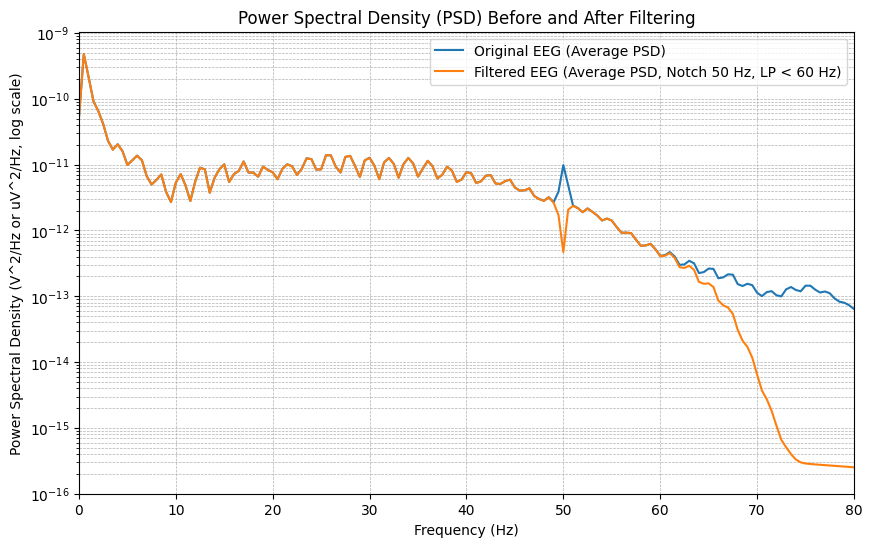

PSD 对比图已生成。请观察在陷波频率和低通截止频率附近是否有明显的功率下降。


In [ ]:
# -*- coding: utf-8 -*-
"""
单元格 5: 绘制滤波效果的 PSD 对比图
目标: 可视化滤波前后的频率成分变化，确认滤波器效果
依赖: raw, raw_filtered, averaged_signal (可选，如果 raw 成功加载),
      signal_after_notch (如果陷波成功), filtered_averaged_signal (如果滤波成功),
      sfreq, powerline_freq, filter_cutoff_freq
"""

# 理想情况下，PSD 应该在应用滤波到整个信号后计算，而不是只在分析段上。
# 这里我们在单元格 4 对整个信号进行了滤波，所以我们可以对整个滤波后的平均信号计算 PSD。
# 我们需要访问在单元格 4 中滤波但可能没有被截取的信号，
# 或者重新计算整个信号的平均和分步滤波，用于 PSD 绘制。

# 简化处理：我们直接对原始 raw 对象和滤波后的 raw_filtered 对象计算 PSD，选取 EEG 通道并平均 PSD。

if 'raw' in locals() and raw is not None and 'raw_filtered' in locals() and raw_filtered is not None:
    print("\n正在计算并绘制滤波前后的功率谱密度 (PSD)...")

    # 使用 mne 的 compute_psd 方法，更方便且能处理多通道
    # fmin=0, fmax=sfreq/2 表示计算整个频率范围
    # picks='eeg' 表示只计算 EEG 通道的 PSD
    # average='mean' 表示对所有选定的通道的 PSD 进行平均
    # method='welch' 使用 Welch 方法计算 PSD
    # n_fft=nperseg_psd 决定窗口大小，影响频率分辨率
    nperseg_psd = int(sfreq * 2) # 例如，使用 2 秒的窗口长度计算 PSD，提供好的频率分辨率

    # 计算原始 EEG 通道数据的平均 PSD
    # 原始 raw 对象没有经过任何滤波
    try:
        # 计算原始 EEG 通道数据的 PSD (移除 average='mean' 以避免混淆)
        psd_spectrum_orig = raw.compute_psd(method='welch', n_fft=nperseg_psd, picks='eeg', verbose=False)
        psd_data_orig = psd_spectrum_orig.get_data() # 获取每个通道的 PSD 数据 (形状通常是: 通道数 x 频率点数)
        freqs_psd = psd_spectrum_orig.freqs # 获取频率向量 (形状是: 频率点数)
        psd_mean_orig = np.mean(psd_data_orig, axis=0) # **关键修改：对获取的数据按通道轴(axis=0)求平均** -> 结果是 (频率点数,)，与 freqs_psd 匹配
        freqs_psd = psd_spectrum_orig.freqs # 获取频率向量
        print("原始 EEG 通道平均 PSD 计算完成。")
    except Exception as e:
        print(f"计算原始信号 PSD 时出错: {e}")
        psd_mean_orig = None
        freqs_psd = None


    # 计算滤波后 EEG 通道数据的平均 PSD
    # raw_filtered 是经过陷波和低通滤波的 raw 对象
    if 'raw_filtered' in locals() and raw_filtered is not None:
        try:
            # 计算滤波后 EEG 通道数据的平均 PSD (移除 average='mean')
            psd_spectrum_filtered = raw_filtered.compute_psd(method='welch', n_fft=nperseg_psd, picks='eeg', verbose=False)
            psd_data_filtered = psd_spectrum_filtered.get_data() # 获取每个通道的 PSD 数据
            freqs_psd_filtered = psd_spectrum_filtered.freqs # 获取频率向量
            psd_mean_filtered = np.mean(psd_data_filtered, axis=0) # **关键修改：对获取的数据按通道轴(axis=0)求平均** -> 结果是 (频率点数,)
            # 频率向量应该与原始的一致，但安全起见重新获取
            freqs_psd_filtered = psd_spectrum_filtered.freqs
            print("滤波后 EEG 通道平均 PSD 计算完成。")
        except Exception as e:
             print(f"计算滤波信号 PSD 时出错: {e}")
             psd_mean_filtered = None
             freqs_psd_filtered = None
    else:
         psd_mean_filtered = None
         freqs_psd_filtered = None


    # --- 绘制 PSD 对比图 ---
    if psd_mean_orig is not None and psd_mean_filtered is not None and freqs_psd is not None:
        plt.figure(figsize=(10, 6))
        # 绘制 PSD (使用 semilogy 使 Y 轴使用对数刻度)
        plt.semilogy(freqs_psd, psd_mean_orig, label='Original EEG (Average PSD)') # 图例英文
        plt.semilogy(freqs_psd_filtered, psd_mean_filtered, label=f'Filtered EEG (Average PSD, Notch {powerline_freq} Hz, LP < {filter_cutoff_freq} Hz)') # 图例英文

        plt.title('Power Spectral Density (PSD) Before and After Filtering') # 图表标题英文
        plt.xlabel('Frequency (Hz)') # 图表标签英文
        plt.ylabel('Power Spectral Density (V^2/Hz or uV^2/Hz, log scale)') # 图表标签英文
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        # 限制 X 轴范围到感兴趣的频率（例如 0 到 70 Hz）
        plt.xlim(0, filter_cutoff_freq + 20) # 稍微超出滤波截止频率，以便看到滚降
        # 设置 Y 轴下限，以便看到较低的功率水平
        # 根据您的数据调整这个值以便清晰显示曲线，避免 log(0) 问题
        plt.ylim(ymin=1e-16)


        plt.show()

        print("PSD 对比图已生成。请观察在陷波频率和低通截止频率附近是否有明显的功率下降。") # 控制台输出，保持汉语

    else:
        print("未能成功计算 PSD。请检查前面的单元格和滤波步骤。")


else:
    print("原始或滤波后的 raw 数据未加载。无法计算 PSD。请检查单元格 2 和 4。")


正在计算并绘制频谱图...
频谱图参数: NFFT=512, noverlap=400


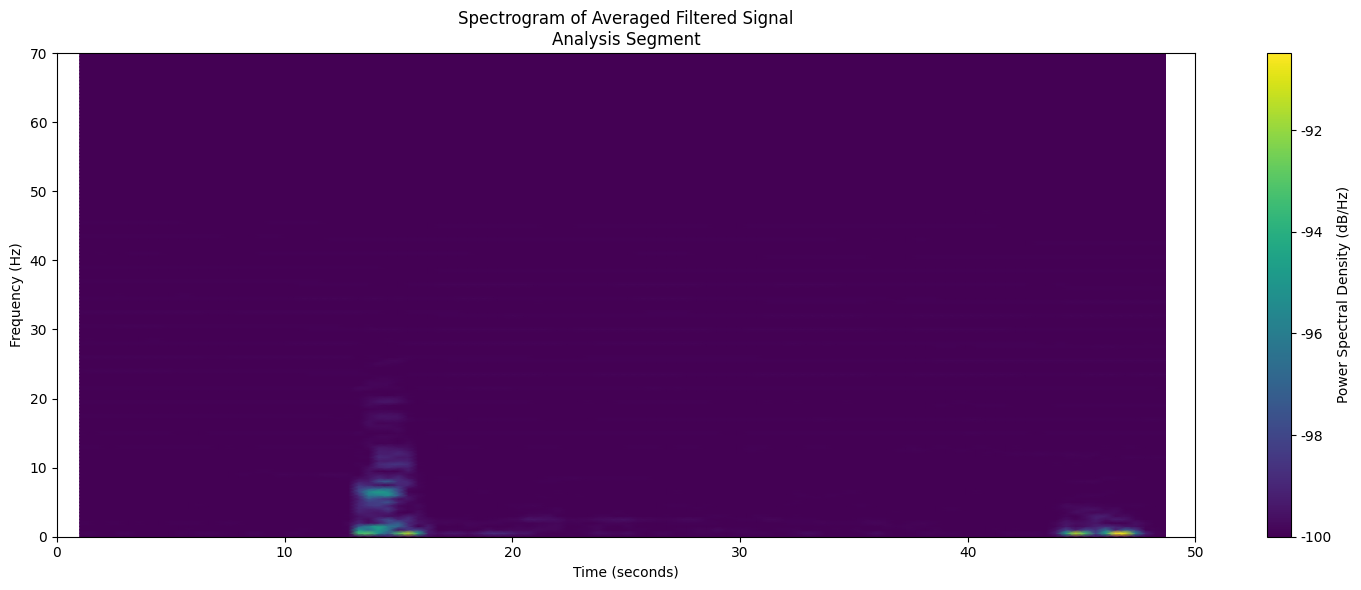

频谱图已生成。
分析时段时长: 50.00 秒
频谱图时间点数: 110
频谱图时间轴范围: 1.00 - 48.69 秒 (绝对时间)


In [ ]:
# -*- coding: utf-8 -*-
"""
单元格 6: 计算并绘制频谱图 (Spectrogram)
目标: 可视化信号在时间和频率上的能量分布
依赖: averaged_analysis_segment, times_analysis_segment, sfreq,
      analysis_start_time, analysis_duration, seizure_onset_time, seizure_duration
"""
# 请确保您已经运行了单元格 4，并且 averaged_analysis_segment 已成功创建。

if 'averaged_analysis_segment' in locals() and averaged_analysis_segment is not None and times_analysis_segment is not None:
    print("\n正在计算并绘制频谱图...")

    # Spectrogram parameters (使用单元格 1 中定义的参数)
    # NFFT: length of each segment.
    # noverlap: number of points to overlap between segments.
    # 确保参数有效
    if nfft_spec > len(averaged_analysis_segment):
        nfft_spec = len(averaged_analysis_segment)
        print(f"Warning: nfft_spec was larger than data length. Adjusted to {nfft_spec}")
    if noverlap_spec >= nfft_spec:
        noverlap_spec = nfft_spec - 1 # noverlap must be less than nfft
        print(f"Warning: noverlap_spec was >= nfft_spec. Adjusted to {noverlap_spec}")
    if nfft_spec <= 0: nfft_spec = 1 # Avoid division by zero


    print(f"频谱图参数: NFFT={nfft_spec}, noverlap={noverlap_spec}") # 控制台输出，保持汉语


    # Compute spectrogram using scipy.signal.spectrogram
    # frequencies_spec (Hz), times_spec_relative (segment centers relative to start), Sxx (Power Spectral Density)
    frequencies_spec, times_spec_relative, Sxx = sig.spectrogram(
        averaged_analysis_segment, # Use the averaged analysis data segment
        fs=sfreq,
        nperseg=nfft_spec, # nperseg 是 spectrogram 函数的参数名，对应 NFFT
        noverlap=noverlap_spec,
        scaling='density' # 'density' (PSD)
        # boundary='zeros' # 默认是 'zeros'
    )

    # Adjust time axis to absolute time relative to original recording start
    # times_spec_relative are segment centers relative to the start of averaged_analysis_segment
    # The start time of averaged_analysis_segment is times_analysis_segment[0] (which is analysis_start_time)
    times_spec_absolute = times_spec_relative + times_analysis_segment[0] # This maps to absolute time

    plt.figure(figsize=(15, 6)) # 图表比例，参考 solution 可能不同

    # Plot spectrogram using pcolormesh
    # Convert PSD to dB scale for visualization (add small epsilon to avoid log10(0))
    # X-axis: times_spec_absolute, Y-axis: frequencies_spec
    plt.pcolormesh(times_spec_absolute, frequencies_spec, 10 * np.log10(Sxx + 1e-10),
                   shading='gouraud', cmap='viridis') # 使用之前讨论的风格

    plt.colorbar(label='Power Spectral Density (dB/Hz)') # Colorbar label英文

    # Title and Labels英文
    plt.title('Spectrogram of Averaged Filtered Signal\nAnalysis Segment') # 标题英文
    plt.xlabel('Time (seconds)') # X-axis absolute time 标签英文
    plt.ylabel('Frequency (Hz)') # 标签英文

    # Set Y-axis range based on analyzed frequencies or filter cutoff
    # plt.ylim(0, frequencies_spec[-1]) # Show up to max frequency calculated
    plt.ylim(0, filter_cutoff_freq + 10) # Limit to filter cutoff + margin

    # Set X-axis range to the actual analysis segment time range
    plt.xlim(times_analysis_segment[0], times_analysis_segment[-1])


    # Mark the original seizure region (if it is within the analysis segment time range)
    if seizure_onset_time is not None and seizure_duration is not None:
         seizure_end_time_orig = seizure_onset_time + seizure_duration
         # Check if seizure overlaps with the analysis segment time range
         analysis_segment_start = times_analysis_segment[0]
         analysis_segment_end = times_analysis_segment[-1]
         if not (seizure_end_time_orig < analysis_segment_start or seizure_onset_time > analysis_segment_end):
               # Plot the overlapping part of the seizure region
               plt.axvspan(max(analysis_segment_start, seizure_onset_time),
                           min(analysis_segment_end, seizure_end_time_orig),
                           color='red', alpha=0.3, label='Seizure Region') # Label英文
               plt.legend()


    plt.tight_layout() # 自动调整布局，避免重叠
    plt.show()

    print("频谱图已生成。") # 控制台输出，保持汉语
    print(f"分析时段时长: {len(averaged_analysis_segment)/sfreq:.2f} 秒") # 控制台输出，保持汉语
    print(f"频谱图时间点数: {len(times_spec_relative)}") # 控制台输出，保持汉语
    print(f"频谱图时间轴范围: {times_spec_absolute[0]:.2f} - {times_spec_absolute[-1]:.2f} 秒 (绝对时间)") # 控制台输出，保持汉语

else:
    print("用于分析的平均信号段未成功创建。无法绘制频谱图。请检查单元格 4。") # 控制台输出，保持汉语


正在计算并绘制小波变换（尺度图）...
正在计算连续小波变换 (CWT) 使用 'cmor1.5-1.0' 小波, 频率范围从 1 Hz 到 50 Hz...
这可能需要一些时间取决于数据长度和尺度数量。


CWT 计算完成。


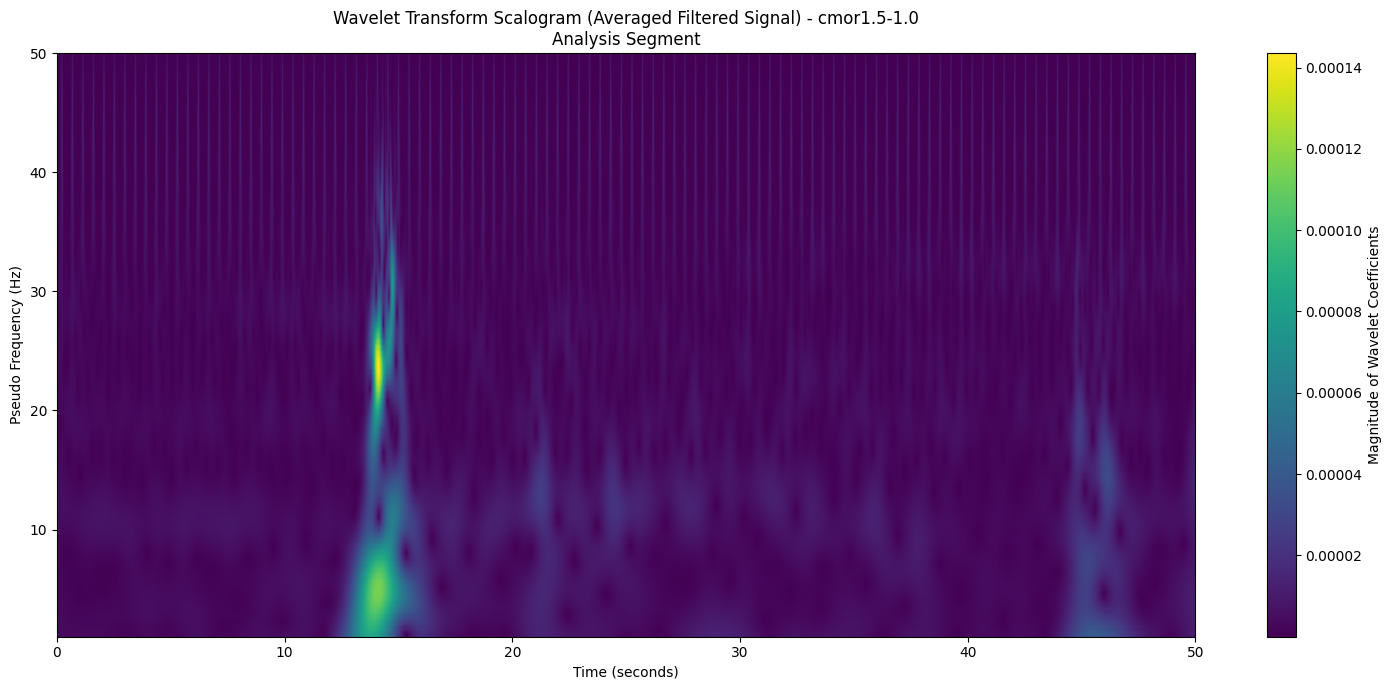

In [ ]:
# -*- coding: utf-8 -*-
"""
单元格 7: 计算并绘制小波变换（尺度图）
目标: 可视化信号在时间和尺度/频率上的特征 (斯氏图)
依赖: averaged_analysis_segment, times_analysis_segment, sfreq,
      analysis_start_time, analysis_duration, seizure_onset_time, seizure_duration, filter_cutoff_freq,
      wavelet_name, min_freq_cwt, max_freq_cwt, num_freqs_cwt
"""
# 请确保您已经运行了单元格 4，并且 averaged_analysis_segment 已成功创建。
# 请确保 pywt 已安装。

if 'averaged_analysis_segment' in locals() and averaged_analysis_segment is not None and times_analysis_segment is not None:
    print("\n正在计算并绘制小波变换（尺度图）...") # 控制台输出，保持汉语

    # Select wavelet basis function and define parameters (使用单元格 1 中定义的参数)
    # Reference uses cmor1.5-1.0
    # Wavelet name, min/max frequencies, number of scales are defined in Cell 1


    # Create a frequency grid for CWT (logarithmic spacing is usually better for scales)
    target_freqs_cwt = np.logspace(np.log10(min_freq_cwt), np.log10(max_freq_cwt), num_freqs_cwt)
    # Convert target frequencies to corresponding wavelet scales using pywt.frequency2scale
    scales_cwt = pywt.frequency2scale(wavelet_name, target_freqs_cwt / sfreq)
    # Ensure scales are sorted from smallest to largest for imshow extent mapping
    scales_cwt = np.sort(scales_cwt)


    print(f"正在计算连续小波变换 (CWT) 使用 '{wavelet_name}' 小波, 频率范围从 {min_freq_cwt} Hz 到 {max_freq_cwt} Hz...") # 控制台输出，保持汉语
    print("这可能需要一些时间取决于数据长度和尺度数量。") # 控制台输出，保持汉语

    # Compute Continuous Wavelet Transform (CWT) using the averaged analysis data segment
    # coeffs: Wavelet coefficients, shape is (number of scales, number of time points)
    # freqs_cwt_result: Pseudo frequencies corresponding to the scales returned by pywt
    # Note: This calculates CWT directly on the analysis segment. Edge effects will be visible.
    coeffs, freqs_cwt_result = pywt.cwt(averaged_analysis_segment, scales_cwt, wavelet_name, sampling_period=1.0/sfreq)
    print("CWT 计算完成。") # 控制台输出，保持汉语

    plt.figure(figsize=(15, 7)) # 图表比例，参考 solution 可能不同

    # Plot the absolute value (magnitude) of CWT coefficients (Scalogram) using imshow
    # extent parameter maps the data array (coeffs) to the plot coordinates (time, frequency)
    # extent=[xmin, xmax, ymin, ymax]
    # xmin, xmax: Time range of the analysis segment (times_analysis_segment)
    # ymin, ymax: Frequency range (using freqs_cwt_result, lowest freq corresponds to largest scale)
    plt.imshow(np.abs(coeffs),
               extent=[times_analysis_segment[0], times_analysis_segment[-1], freqs_cwt_result[-1], freqs_cwt_result[0]],
               aspect='auto', cmap='viridis', origin='upper') # origin='upper' 使频率从低到高显示在 Y 轴下方

    plt.colorbar(label='Magnitude of Wavelet Coefficients') # Colorbar label英文

    # Title and Labels英文
    plt.title(f'Wavelet Transform Scalogram (Averaged Filtered Signal) - {wavelet_name}\nAnalysis Segment') # 标题英文
    plt.xlabel('Time (seconds)') # X-axis absolute time 标签英文
    plt.ylabel('Pseudo Frequency (Hz)') # 标签英文

    # Set Y-axis range based on analyzed frequencies
    plt.ylim(min_freq_cwt, max_freq_cwt) # Limit Y-axis to the frequency range analyzed by CWT

    # Set X-axis range to the analysis segment time range
    plt.xlim(times_analysis_segment[0], times_analysis_segment[-1]) # Plot the entire analysis segment


    # Mark the original seizure region (if it is within the analysis segment time range)
    if seizure_onset_time is not None and seizure_duration is not None:
         seizure_end_time_orig = seizure_onset_time + seizure_duration
         # Check if seizure overlaps with the analysis segment time range
         analysis_segment_start = times_analysis_segment[0]
         analysis_segment_end = times_analysis_segment[-1]
         if not (seizure_end_time_orig < analysis_segment_start or seizure_onset_time > analysis_segment_end):
               # Plot the overlapping part of the seizure region
               plt.axvspan(max(analysis_segment_start, seizure_onset_time),
                           min(analysis_segment_end, seizure_end_time_orig),
                           color='red', alpha=0.3, label='Seizure Region') # Label英文
               plt.legend()

    plt.tight_layout() # 自动调整布局，避免重叠
    plt.show()

else:
    print("用于分析的平均信号段未成功创建。无法绘制小波变换。请检查单元格 4。") # 控制台输出，保持汉语